In [1]:
from typing import Dict, List, Tuple
import glob
import re
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
data_dir = '../data/'

In [4]:
files = glob.glob(data_dir + 'etl_s2_v2*.parquet')
files

['../data/etl_s2_v2_1680112320_1680265920.parquet',
 '../data/etl_s2_v2_1679805120_1679958720.parquet',
 '../data/etl_s2_v2_1679958720_1680112320.parquet',
 '../data/etl_s2_v2_1679178240_1679331840.parquet',
 '../data/etl_s2_v2_1679485440_1679651520.parquet',
 '../data/etl_s2_v2_1679651520_1679805120.parquet',
 '../data/etl_s2_v2_1679331840_1679485440.parquet']

In [5]:
tickers = ['BTC-USD','ETH-USD','MKR-USD','BCH-USD','COMP-USD','AAVE-USD','UNI-USD','CRV-USD','BAL-USD','LTC-USD','ADA-USD','XLM-USD','ALGO-USD','ZEC-USD','DOGE-USD','SHIB-USD','SUSHI-USD','EOS-USD','ETC-USD','WBTC-USD']

In [6]:
data = pd.read_parquet(files[0])
columns = data.columns

In [7]:
def get_ticker_columns(ticker, columns, const_columns):
    cols = [col for col in columns if col.startswith(ticker) or col in const_columns]
    return cols

In [8]:
def get_column_field(column, const_columns):
    if column in const_columns:
        return column
    m = re.match(r'[a-zA-Z-]+:(.*)$', column)
    return m.group(1)

In [9]:
target_columns = [
    ('book_volatility_9',   9,   'book_volatility_9_target'),
    ('book_volatility_27',  27,  'book_volatility_27_target'),
    ('book_volatility_81',  81,  'book_volatility_81_target'),
    ('book_volatility_162', 162, 'book_volatility_162_target'),
    ('book_volatility_324', 324, 'book_volatility_324_target'),
    ('book_volatility_648', 648, 'book_volatility_648_target'),
    ('book_volatility_960', 960, 'book_volatility_960_target'),
]

In [10]:
target_column_names = [name for (_, _, name) in target_columns]

In [11]:
def get_all_data(files, columns, tickers, const_columns):
    all_tickers = []
    for ticker in tickers:
        tcolumns = get_ticker_columns(ticker, columns, const_columns)
        colmap = {col : get_column_field(col, const_columns) for col in tcolumns}
        dfs = []
        for file in files:
            df = pd.read_parquet(file, columns=tcolumns)
            df = df.rename(columns=colmap)
            dfs.append(df)
        df = pd.concat(dfs)
        df.sort_index(inplace=True)
        #it's possible we're missing index in the middle, so the target is not completely right
        #TODO: remove rows where the gap from previous is bigger than 1 second
        for (orig_col, offset, target_col) in target_columns:
            df[target_col] = df[orig_col].shift(-1 * offset)
        # doing best effort forward fill NaN and Inf
        df.fillna(method='ffill', inplace=True)
        df.replace([float("inf"), float("-inf")], method='ffill', inplace=True)
        df['ticker'] = ticker
        all_tickers.append(df)
    out = pd.concat(all_tickers)
    out.sort_index(inplace=True)
    return out

In [12]:
# only have enough memory to do 3 files
data = get_all_data(files[4:], columns, tickers, ['book_mean_return_27', 'sequence_interval_s'])

In [13]:
data.shape

(9179140, 718)

In [14]:
data.head(20)

,sequence_interval_s,bid_volume_change_648absavg,wap_162avg,bid_level_intercept_648std,ba_imbalance_extended_3skew,ba_imbalance_extended_9kurt,best_bid_price_648avg,bid_volume_change_27absavg,ba_spread_162kurt,trade_size_648kurt,...,ba_imbalance_extended_960avg,bid_volume_change_162absavg,book_volatility_9_target,book_volatility_27_target,book_volatility_81_target,book_volatility_162_target,book_volatility_324_target,book_volatility_648_target,book_volatility_960_target,ticker
1679331840,1,33249.292969,27637.105469,8.327891e+08,-0.706990,5.976481,27657.191406,27309.947266,2.635938,712.143188,...,3.345720e-02,28155.982422,0.000180,0.000176,0.000179,0.000178,0.000167,0.000160,0.000161,BTC-USD
1679331840,1,6088.691406,683.160095,2.610786e+04,0.550202,2.937765,685.796875,10931.855469,2.599185,16.870544,...,-2.582827e-01,6733.584961,0.000360,0.000343,0.000320,0.000319,0.000340,0.000310,0.000297,MKR-USD
1679331840,1,8573.019531,132.235550,2.519934e+01,0.505813,7.783987,132.611893,6156.821289,2.790174,14.407163,...,4.755855e-01,7230.234375,0.000325,0.000299,0.000259,0.000228,0.000209,0.000204,0.000196,BCH-USD
1679331840,1,120847.023438,19.960941,2.886649e+02,0.689774,4.127807,20.096405,21759.667969,NaN,26.885462,...,-1.124822e+01,58578.183594,0.000373,0.000296,0.000273,0.000273,0.000264,0.000264,0.000256,ETC-USD
1679331840,1,32463.962891,44.372639,6.387133e+01,0.048942,8.314352,44.550415,5851.000488,4.252260,40.386078,...,-1.701442e+00,14695.773438,0.000349,0.000391,0.000358,0.000343,0.000363,0.000340,0.000329,COMP-USD
1679331840,1,20724.619141,76.969185,2.669424e+01,-0.571391,3.615506,77.159660,10710.440430,3.304623,15.209694,...,1.597323e-01,22402.755859,0.000291,0.000306,0.000275,0.000253,0.000251,0.000234,0.000220,AAVE-USD
1679331840,1,9014.381836,1.176713,7.902488e+02,-0.106712,4.977887,1.182481,2621.968506,2.143839,22.747694,...,-1.384290e+02,8972.691406,0.000488,0.000400,0.000357,0.000314,0.000274,0.000265,0.000268,EOS-USD
1679331840,1,17756.976562,6.297132,3.657369e+02,-0.687417,3.753019,6.320437,285.482025,NaN,49.837540,...,1.857622e+01,13638.781250,0.000214,0.000294,0.000269,0.000234,0.000222,0.000210,0.000200,UNI-USD
1679331840,1,1063.286255,27636.326172,5.723858e+09,NaN,NaN,27650.082031,594.279724,6.831756,10.141756,...,9.682839e-04,663.052063,0.001206,0.000785,0.000626,0.000580,0.000492,0.000522,0.000522,WBTC-USD
1679331840,1,3920.491943,1.179334,2.916450e+02,-0.705584,8.292817,1.184192,3102.192139,4.596742,11.790140,...,-7.406264e+01,3527.128174,0.000549,0.000515,0.000430,0.000463,0.000450,0.000393,0.000361,SUSHI-USD


In [15]:
data['ticker'] = data.ticker.astype('category')

In [16]:
data = data.drop([data.index[k] for k in range(-1, -961 * len(tickers), -1)])

In [17]:
data.shape

(9159920, 718)

In [18]:
input_columns = [col for col in data.columns if col not in target_column_names]

In [19]:
data.isna().sum().sum()

24982

In [20]:
for col in data.columns:
    max_val = np.nanmax(data[col][data[col] != np.inf])
    min_val = np.nanmin(data[col][data[col] != -np.inf])
    data[col].replace([np.inf, -np.inf], [max_val, min_val], inplace=True)

In [21]:
data.fillna(0., inplace=True)

In [22]:
ETH_data = data.query("ticker == 'ETH-USD'")

In [23]:
X = data[input_columns]
X = X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [24]:
Y = data[target_column_names]

In [25]:
ETH_X = ETH_data[input_columns]
ETH_X = ETH_X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [26]:
ETH_Y = ETH_data[target_column_names]

In [27]:
def ts_train_test_split(X, Y, pct):
    min_idx = X.index.min()
    max_idx = X.index.max()
    sidx = int((max_idx - min_idx) * (1. - pct) + min_idx)
    X_train = X.loc[:sidx]
    Y_train = Y.loc[:sidx]
    X_test = X.loc[sidx:]
    Y_test = Y.loc[sidx:]
    return (X_train, Y_train, X_test, Y_test)

In [28]:
X_train, Y_train, X_test, Y_test = ts_train_test_split(X, Y, 0.2)

In [29]:
_, _, ETH_X_test, ETH_Y_test = ts_train_test_split(ETH_X, ETH_Y, 0.2)

In [30]:
# should I also normalize the data ?

In [31]:
XYTrain = xgb.DMatrix(X_train, Y_train, enable_categorical=True)

In [32]:
XYTest = xgb.DMatrix(X_test, Y_test, enable_categorical=True)

In [33]:
results: Dict[str, Dict[str, List[float]]] = {}

In [34]:
model = xgb.train(
    {
    "tree_method" : "hist",
    },
    dtrain=XYTrain,
    num_boost_round=23,
    evals=[(XYTrain, "Train"), (XYTest, "Validation")],
    evals_result=results,
)

[0]	Train-rmse:0.34988	Validation-rmse:0.34995
[1]	Train-rmse:0.24492	Validation-rmse:0.24498
[2]	Train-rmse:0.17144	Validation-rmse:0.17151
[3]	Train-rmse:0.12001	Validation-rmse:0.12007
[4]	Train-rmse:0.08401	Validation-rmse:0.08406
[5]	Train-rmse:0.05881	Validation-rmse:0.05885
[6]	Train-rmse:0.04116	Validation-rmse:0.04120
[7]	Train-rmse:0.02881	Validation-rmse:0.02885
[8]	Train-rmse:0.02017	Validation-rmse:0.02020
[9]	Train-rmse:0.01412	Validation-rmse:0.01414
[10]	Train-rmse:0.00988	Validation-rmse:0.00990
[11]	Train-rmse:0.00692	Validation-rmse:0.00693
[12]	Train-rmse:0.00484	Validation-rmse:0.00486
[13]	Train-rmse:0.00339	Validation-rmse:0.00340
[14]	Train-rmse:0.00237	Validation-rmse:0.00238
[15]	Train-rmse:0.00166	Validation-rmse:0.00167
[16]	Train-rmse:0.00117	Validation-rmse:0.00117
[17]	Train-rmse:0.00082	Validation-rmse:0.00083
[18]	Train-rmse:0.00057	Validation-rmse:0.00058
[19]	Train-rmse:0.00041	Validation-rmse:0.00041
[20]	Train-rmse:0.00029	Validation-rmse:0.00029
[2

In [35]:
Y_predict = model.inplace_predict(X_test)

In [36]:
# looking at individual target dimension r2 and pearson correlation

In [37]:
r2_score(Y_test.to_numpy()[:,0], Y_predict[:,0])

-2.582050173345496

In [38]:
r, p = pearsonr(Y_test.to_numpy()[:,0], Y_predict[:,0])
r

0.47061587470221705

In [39]:
r2_score(Y_test.to_numpy()[:,3], Y_predict[:,3])

-6.254142214229352

In [40]:
r, p = pearsonr(Y_test.to_numpy()[:,3], Y_predict[:,3])
r

0.6880987160628907

In [41]:
r2_score(Y_test.to_numpy()[:,6], Y_predict[:,6])

-9.71074674918305

In [42]:
r, p = pearsonr(Y_test.to_numpy()[:,6], Y_predict[:,6])
r

0.7043640557234172

In [43]:
r2_score(Y_test.to_numpy(), Y_predict)

-6.21051281355181

In [44]:
# validate only on ETH-USD test data

In [45]:
Y_predict = model.inplace_predict(ETH_X_test)

In [46]:
r2_score(ETH_Y_test.to_numpy()[:,0], Y_predict[:,0])

-8.465005605873909

In [47]:
r, p = pearsonr(ETH_Y_test.to_numpy()[:,0], Y_predict[:,0])
r

0.5466683354909401

In [48]:
r2_score(ETH_Y_test.to_numpy()[:,3], Y_predict[:,3])

-19.134432889711263

In [49]:
r, p = pearsonr(ETH_Y_test.to_numpy()[:,3], Y_predict[:,3])
r

0.6412104296053408

In [50]:
r2_score(ETH_Y_test.to_numpy()[:,6], Y_predict[:,6])

-27.681345837100608

In [51]:
r, p = pearsonr(ETH_Y_test.to_numpy()[:,6], Y_predict[:,6])
r

0.5757358753384293

In [52]:
r2_score(ETH_Y_test.to_numpy(), Y_predict)

-18.74836616958566

In [53]:
# plotting out target vs prediction in validation

In [54]:
x_axis = ETH_Y_test.index.to_numpy()

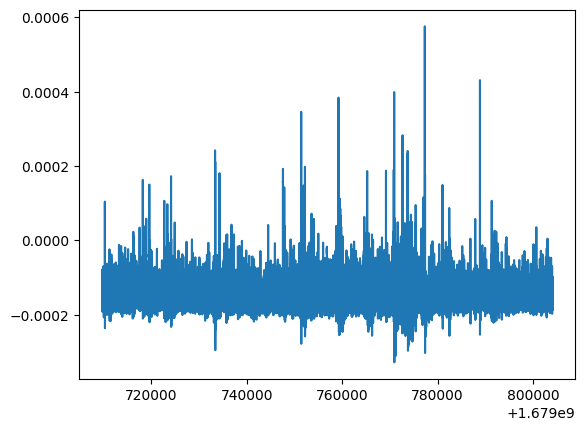

In [55]:
diff0 = ETH_Y_test.to_numpy()[:,0] - Y_predict[:,0]
plt.plot(x_axis, diff0)

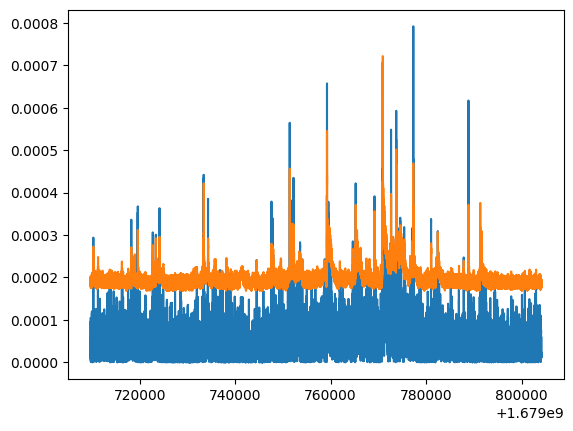

In [56]:
plt.plot(x_axis, ETH_Y_test.to_numpy()[:,0])
plt.plot(x_axis, Y_predict[:,0])

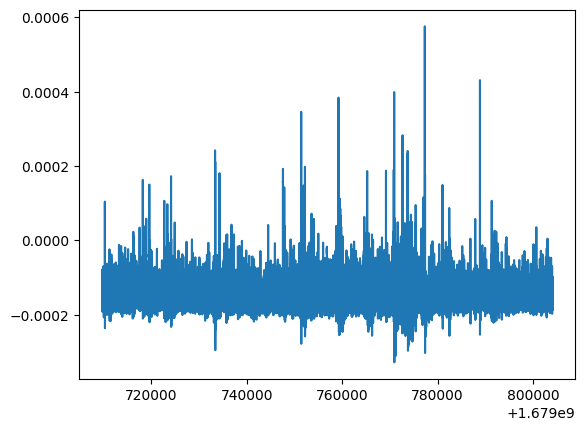

In [57]:
diff3 = ETH_Y_test.to_numpy()[:,3] - Y_predict[:,3]
plt.plot(x_axis, diff0)

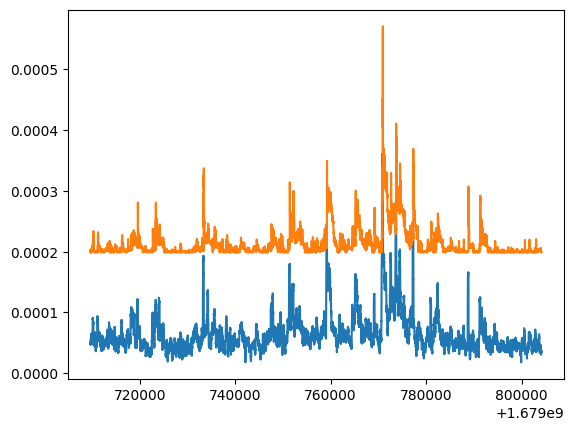

In [58]:
plt.plot(x_axis, ETH_Y_test.to_numpy()[:,3])
plt.plot(x_axis, Y_predict[:,3])

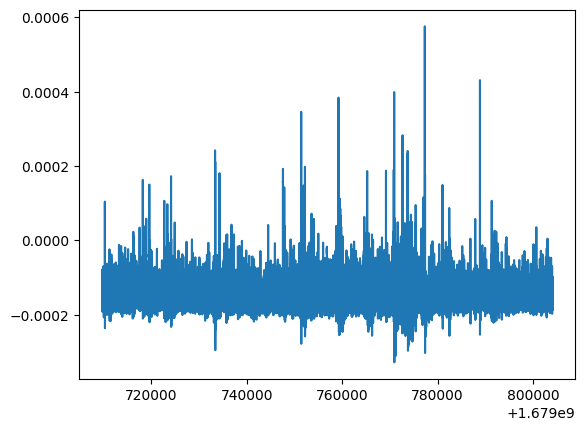

In [59]:
diff6 = ETH_Y_test.to_numpy()[:,6] - Y_predict[:,6]
plt.plot(x_axis, diff0)

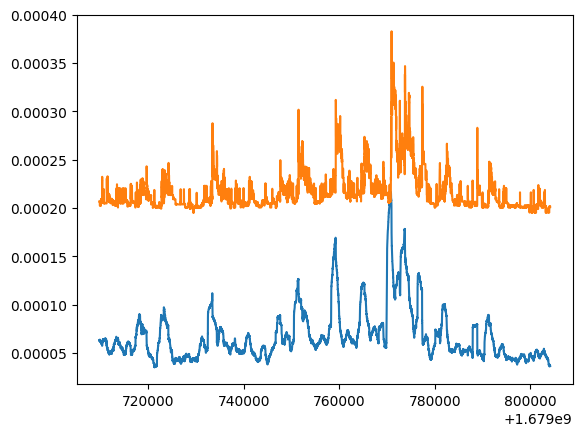

In [60]:
plt.plot(x_axis, ETH_Y_test.to_numpy()[:,6])
plt.plot(x_axis, Y_predict[:,6])